In [1]:
%matplotlib inline

morange = u'#ff7f0e'
mblue = u'#1f77b4'
mgreen = u'#2ca02c'
mred = u'#d62728'
mpurple = u'#9467bd'

In [25]:
import os
dirname = "/Volumes/simulation_data_2018/protoDC2_v4"
basename_z0p00 = "umachine_color_mock_v4_m000-499.hdf5"
basename_z0p25 = "umachine_color_mock_v4_m000-392.hdf5"
basename_z0p50 = "umachine_color_mock_v4_m000-331.hdf5"
basename_z0p75 = "umachine_color_mock_v4_m000-286.hdf5"
basename_z1p00 = "umachine_color_mock_v4_m000-253.hdf5"

redshift = 0.5
if redshift == 0.0:
    basename = basename_z0p00
elif redshift == 0.25:
    basename = basename_z0p25
elif redshift == 0.5:
    basename = basename_z0p50
elif redshift == 0.75:
    basename = basename_z0p75
if redshift == 1.0:
    basename = basename_z1p00


Lbox = 256.
Lbox_physical = Lbox/(1. + redshift)
Veff = Lbox_physical**3.


fname = os.path.join(dirname, basename)

from astropy.table import Table
mock = Table.read(fname, path='data')
mock['redshift'] = redshift

print(mock.keys())

['source_halo_id', 'target_halo_id', 'target_halo_x', 'target_halo_y', 'target_halo_z', 'target_halo_vx', 'target_halo_vy', 'target_halo_vz', 'target_halo_mass', 'host_halo_mvir', 'upid', 'mpeak', 'host_centric_x', 'host_centric_y', 'host_centric_z', 'host_centric_vx', 'host_centric_vy', 'host_centric_vz', 'obs_sm', 'obs_sfr', 'sfr_percentile', 'restframe_extincted_sdss_abs_magr', 'restframe_extincted_sdss_gr', 'restframe_extincted_sdss_ri', 'is_on_red_sequence_gr', 'is_on_red_sequence_ri', 'x', 'vx', 'y', 'vy', 'z', 'vz', 'lightcone_id', 'redshift']


In [26]:
from cosmodc2.stellar_mass_remapping import lift_high_mass_mstar

mock['new_mstar'] = lift_high_mass_mstar(
        mock['mpeak'], mock['obs_sm'], mock['redshift'], z_table=[0.35, 0.5, 1], 
        slope_table=[0.5, 0.65, 0.8], pivot_table=[13.25, 13, 12.5])

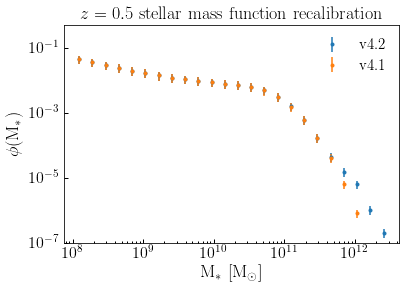

In [32]:
logsm_bins = np.linspace(8, 12.5, 25)
logsm_mids = 0.5*(logsm_bins[:-1] + logsm_bins[1:])
sm_bins = 10**logsm_bins
sm_mids = 10**logsm_mids

smf_old = np.zeros_like(logsm_mids)
smf_new = np.zeros_like(logsm_mids)

for i, sm_low, sm_high in zip(range(len(logsm_mids)), sm_bins[:-1], sm_bins[1:]):
    orig_sm_mask = (mock['obs_sm'] > sm_low) & (mock['obs_sm'] < sm_high)
    new_sm_mask = (mock['new_mstar'] > sm_low) & (mock['new_mstar'] < sm_high)
    smf_old[i] = np.count_nonzero(orig_sm_mask)/Veff
    smf_new[i] = np.count_nonzero(new_sm_mask)/Veff
    
fig, ax = plt.subplots(1, 1)

__=ax.loglog()

__=ax.errorbar(sm_mids, smf_new, 0.3*smf_new, fmt='.', 
               label=r'${\rm v4.2}$', color=mblue)
__=ax.errorbar(sm_mids, smf_old, 0.3*smf_old, fmt='.', 
               label=r'${\rm v4.1}$', color=morange)

ylim = ax.set_ylim(1e-7, 0.5)
legend = ax.legend()

xlabel = ax.set_xlabel(r'${\rm M_{\ast}\ [M_{\odot}]}$')
ylabel = ax.set_ylabel(r'$\phi({\rm M_{\ast}})$')
title = ax.set_title(r'$z=0.5\ {\rm stellar\ mass\ function\ recalibration}$')

figname = 'smf_recalibration_v4p2.pdf'
# fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')